In [0]:
!nvidia-smi

Wed Apr  8 12:07:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%matplotlib inline

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
from torch.utils.data import DataLoader, Dataset
from torch import nn
import random
import csv
import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = False
import time
import math
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

In [0]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
class Data(Dataset):

    def __init__(self,location,train=True): 

        self.all_letters = string.ascii_letters + "0123456789 .,:!?'[]()/+-="
        self.n_letters = len(self.all_letters) + 1 # Plus EOS marker

        # Build the category_lines dictionary, a list of lines per category
        self.category_lines,self.all_categories, self.max_len= self.get_data(location)
        self.n_categories = len(self.all_categories)
        random.seed(0)
        random.shuffle(self.category_lines['st'])
        self.data=[]
        cut = int(0.8*len(self.category_lines['st']))
        if train:
            self.data=[i for i in self.category_lines['st'][:cut]]
        else:
            self.data=[i for i in self.category_lines['st'][cut:]]
    
    def __getitem__(self, idx):
        line = self.data[idx]
        input_line_tensor = self.inputTensor(line)
        target_line_tensor = self.targetTensor(line)
        if torch.cuda.is_available():
            return input_line_tensor.cuda(), target_line_tensor.cuda()
        else:
            return input_line_tensor, target_line_tensor
    
    def __len__(self):
      return len(self.data)

    def get_data(self,location):
        category_lines = {}
        all_categories = ['st']
        category_lines['st']=[]
        filterwords=['NEXTEPISODE']
        max_len = 0
        with open(location, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quotechar='"')
            for row in reader:
                for el in row:
                    if (el not in filterwords) and (len(el)>1):
                        v=el.strip().replace(";","").replace('\"','')
                        category_lines['st'].append(v)
                        if len(v)>max_len:
                            max_len = len(v)
                        # try:
                        #     if v[0].isupper() and v[0] != 'Q' and v[0] != 'X' and v[1].isupper():
                        #         category_lines['st'].append(v)
                        # except:
                        #     pass

        n_categories = len(all_categories)
        return category_lines,all_categories,max_len


    def findFiles(self,path): return glob.glob(path)

    # Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
    def unicodeToAscii(self,s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
            and c in self.all_letters
        )

    # Read a file and split into lines
    def readLines(self,filename):
        lines = open(filename, encoding='utf-8').read().strip().split('\n')
        return [self.unicodeToAscii(line) for line in lines]

    # One-hot vector for category
    def categoryTensor(self,category):
        li = self.all_categories.index(category)
        tensor = torch.zeros(1, self.n_categories)
        tensor[0][li] = 1
        return tensor

    # One-hot matrix of first to last letters (not including EOS) for input
    def inputTensor(self,line):
        tensor = torch.zeros(len(line), 1, self.n_letters)
        for li in range(len(line)):
            letter = line[li]
            tensor[li][0][self.all_letters.find(letter)] = 1
        # for li in range(len(line),self.max_len):
        #     tensor[li][0][self.n_letters - 1] = 1       # Pad with EOS token
        return tensor

    # LongTensor of second letter to end (EOS) for target
    def targetTensor(self,line):
        letter_indexes = [self.all_letters.find(line[li]) for li in range(1, len(line))]
        letter_indexes.append(self.n_letters - 1) # EOS
        return torch.LongTensor(letter_indexes)


In [0]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, h):
        out, hidden = self.lstm(x, h)
        out = self.dropout(out)
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        if torch.cuda.is_available():
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                    weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                    weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [0]:
def pad_collate(batch):
    xpad = pad_sequence([datum[0] for datum in batch], padding_value = 0, batch_first=True)
    y = pad_sequence([datum[1] for datum in batch], padding_value = 0, batch_first=True)
    return [xpad, y]

In [0]:
def sample(model,test_set,device,start_letter='S'):
    model.eval()
    max_length = 100
    with torch.no_grad():  # no need to track history in sampling
        input = test_set.inputTensor(start_letter).to(device)
        hidden = model.init_hidden(1)

        sequence = start_letter

        for i in range(max_length):
            output, hidden = model(input, hidden)
            distribution = torch.softmax(torch.div(torch.flatten(output), 0.5), dim=0)
            distribution = torch.distributions.multinomial.Multinomial(1, distribution)
            samp = distribution.sample()
            topi = torch.argmax(samp)
            if topi == test_set.n_letters - 1:
                break
            else:
                letter = test_set.all_letters[topi]
                sequence += letter
            input = test_set.inputTensor(letter).to(device)

        return sequence

In [0]:
def train(model,criterion,optimizer,input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = model.init_hidden(1)
    hidden = tuple([e.data for e in hidden])
    model.zero_grad()
    
    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = model(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i].flatten())
        loss += l

    loss.backward()
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

def evaluate(model,criterion,test_loader):
    for counter,(input_tensor, target_tensor) in enumerate(test_loader):
        target_tensor.unsqueeze_(-1)
        hidden = model.init_hidden(1)
        hidden = tuple([e.data for e in hidden])
        num_correct = 0
        total = 0
        loss = 0
        for i in range(input_tensor.size(0)):
            output, hidden = model(input_tensor[i], hidden)
            l = criterion(output, target_tensor[i].flatten())
            loss += l
            output = torch.argmax(output,dim=1)
            num_correct += sum(output==target_tensor.flatten()).item()
            total += len(output)

    return (num_correct/total), loss.item()


In [0]:
def run(): 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    path = "/content/gdrive/Shared drives/Team Drive/School/Deep Learning/DL_HW6/star_trek_transcripts_all_episodes_f.csv"
    train_set = Data(path, train=True)
    test_set = Data(path, train=False)


    model = LSTMNet(test_set.n_letters, 100, test_set.n_letters, 2)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.0005
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    start_letters = "ABCDEFGHIJKLMNOPRSTUVWZ"
    batch_size=5
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=True)


    n_iters = len(train_set)/batch_size
    # print_every = 2000
    train_losses = []
    test_losses = []
    test_accuracies = []
    max_acc = 0
    # start = time.time()

    for epoch in range(20):
        print("Epoch ", epoch)
        total_loss = 0
        model.train()
        for counter,(input_tensor, target_tensor) in enumerate(train_loader):
            output, loss = train(model,criterion,optimizer,input_tensor, target_tensor)
            total_loss += loss

            # if counter==0:
            #     pass
            # elif counter % print_every ==0:
            #     print(total_loss/(counter+1))
            #     print(str(round(counter/n_iters,2))+"% completed")
        train_losses.append(total_loss/(counter+1))
        for idx in range(5):
            print(sample(model,test_set,device,random.choice(start_letters)))
        model.eval()
        test_acc, test_loss = evaluate(model,criterion,test_loader)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        if test_acc > max_acc:
            max_acc = test_acc
            best_model_wts = model.state_dict()

    torch.save(best_model_wts,'/content/gdrive/Shared drives/Team Drive/School/Deep Learning/DL_HW6/model.pt')
    plt.plot(train_losses, label = "Train Loss")
    plt.plot(test_losses, label = "Test Loss")
    plt.plot(test_accuracies, label = "Test Accuracy")
    plt.legend()
    plt.title("Report")
    plt.show()

Epoch  0
Waver in instrent that con a mith the canter the not to the krow of the deathit to as as as ene you d
MCCOY: Whe don't fion. It you are and there of the wist his to wall sour.
Hand is the seening be all stonter it
FOVET: And the know whe all suptent of the the manse ponter the planser of whe a wan the priser the p
PCOTT: I courder prices eredcored the the canled.
Epoch  1
Captain.
TRELELI: Yes
Jis contain to that the dake the trongers prowiting to the something to comment.
ELATER: Not on the simpless
Captain
Epoch  2
I'm going to starly pains will is a ala simond.
SPOCK: They are not entile on the sursem. The Klingons me the field dight to be a srip.
PIKE: I have the computer triggle
HELLE: The like to you.
Linutenant officer his mind contain
Epoch  3
DEELE: That's the captain could answer in the medical a ready and the some powers in the reather. The
VANDA: I have to the hope that happened.
BARSEL: In the satil seems in the ship with your strongs. Kirk.
RARA: I couldn't get c

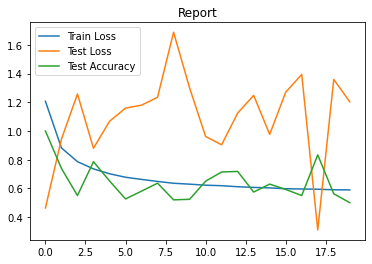

In [0]:
if __name__ == "__main__":
    run()